In [1]:
import json, os
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches, patheffects
import numpy as np
import seaborn as sns
import pandas as pd
from skimage.measure import block_reduce
import urllib.request
import imageio
from tqdm import tqdm_notebook as tqdm

## Cloud dataset - basic setup

In [2]:
IMG_PATH = '/local/S.Rasp/MPI_Aqua/raw/'

In [3]:
with open('labelbox_annotations/labelbox_0821.json', 'r') as f:
    data_new = json.load(f)

In [4]:
# Get all unique image fns
fns = list(set([d['External ID'] for d in data_new]))

In [5]:
sz = np.array(Image.open(IMG_PATH+fns[0])).shape[:-1]; sz

(1144, 1140)

In [6]:
labeler = {d['External ID']: d['Created By'] for d in data_new}

In [7]:
MASK_PATH = '/local/S.Rasp/MPI_Aqua/masks/raw/'

In [8]:
labels = defaultdict(list)
for d in data_new:
    cats = d['Label']
    l = d['Created By']
    fn = d['External ID']
    if 'No fit' in cats.keys():
        labels[fn] = []
    else:
        for i, c in enumerate(list(cats.keys())):
            xs = [cats[c][0]['geometry'][i]['x'] for i in range(4)]
            ys = [cats[c][0]['geometry'][i]['y'] for i in range(4)]
#             bl_x = d['Label'][c][0]['geometry'][1]['x']
#             bl_y = d['Label'][c][0]['geometry'][1]['y']
#             tr_x = d['Label'][c][0]['geometry'][3]['x']
#             tr_y = d['Label'][c][0]['geometry'][3]['y']
            bl_x = np.min(xs); bl_y = np.min(ys)
            tr_x = np.max(xs); tr_y = np.max(ys)
            msk_fn = MASK_PATH + fn[:-4] + f'_m{i}.png'
            print(msk_fn)
            if not os.path.exists(msk_fn):
                print('Downloading')
                urllib.request.urlretrieve(d['Masks'][c], msk_fn)
            labels[fn].append([c, (bl_x, bl_y, tr_x, tr_y), l, msk_fn])

/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170228_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170227_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170218_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170216_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170212_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170210_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170209_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170209_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170208_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170208_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170207_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170207_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_CorrectedReflectance20170206_m0.png
/local/S.Rasp/MPI_Aqua/masks/raw/Aqua_

In [9]:
# Count classes
classes = [list(d['Label'].keys()) for d in data_new if d['Label'] != 'Skip']
classes = [item for sublist in classes for item in sublist]

In [10]:
classes = pd.Series(classes)

In [11]:
classes.value_counts()

Shallow      385
No fit       284
Cold pool    198
Flower       168
Fishbone     118
dtype: int64

In [12]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0],a[3]-a[1]])

In [13]:
def show_img(fn, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(10,10))
    img = Image.open(IMG_PATH + fn)
    ax.imshow(np.flipud(img), origin='lower')
    for l in labels[fn]:
        bb = bb_hw(l[1])
        patch = ax.add_patch(
            patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='red', lw=2))
#         print(l[1], bb)
        text = ax.text(*bb[:2], l[0] + ' ' + l[2], horizontalalignment='left',
                verticalalignment='bottom', color='red', fontsize=15, weight='bold')

In [14]:
cats = list(set(classes)); cats

['Flower', 'Fishbone', 'Shallow', 'Cold pool', 'No fit']

In [15]:
cats = ['No fit', 'Flower', 'Fishbone', 'Shallow', 'Cold pool']

In [16]:
cat2id = {c: i for i, c in enumerate(cats)}

## Prepare the masks

In [111]:
cat2id

{'No fit': 0, 'Flower': 1, 'Fishbone': 2, 'Shallow': 3, 'Cold pool': 4}

In [112]:
for fn, l in tqdm(labels.items()):
    
    ms = []
    for ll in l:
        bb = ll[1]
        m = np.zeros(sz)
        m[bb[1]:bb[3],bb[0]:bb[2]] = cat2id[ll[0]]
        ms.append(m)
    if len(l) > 1:
        ms_bin = [np.greater(m, 0) for m in ms]
        ms = np.array(ms)
        ms_bin = np.array(ms_bin)
        overlap = np.equal(np.mean(ms, 0), ms[0])
        tot_msk = np.mean(ms, 0)
        too_many = (overlap == 0) & (np.sum(ms_bin, 0) > 1)
        one_cat  = (overlap == 0) & (np.sum(ms_bin, 0) == 1)
        tot_msk[too_many] = 0; tot_msk[one_cat] = np.max(ms, 0)[one_cat]
    elif len(l) == 1:
        tot_msk = m
    else:
        tot_msk = np.zeros(sz)
    tot_msk = np.flipud(tot_msk.astype('uint8'))
    imageio.imsave(MASK_PATH + fn, tot_msk)

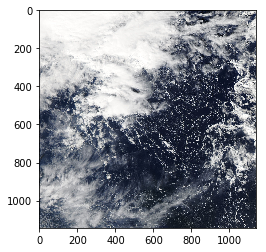

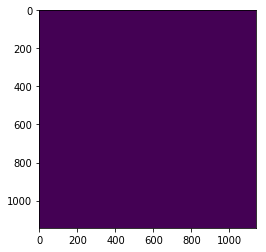

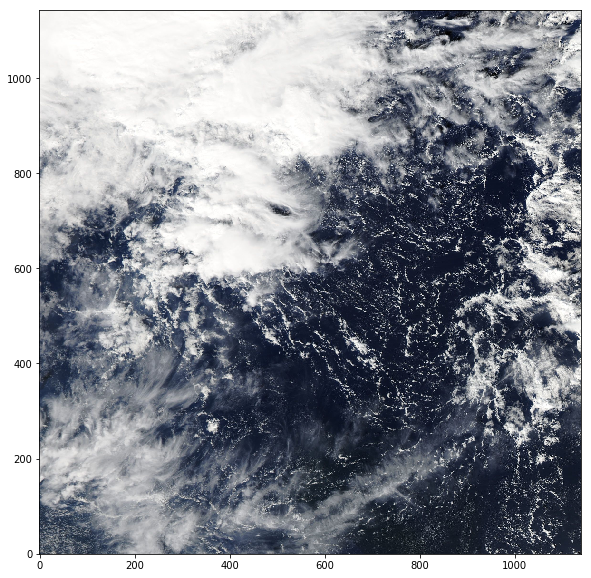

In [113]:
fn = fns[5]
plt.imshow(Image.open(IMG_PATH + fn)); plt.show()
plt.imshow(np.array(Image.open(MASK_PATH + fn))); plt.show()
show_img(fns[5])

### convert

In [18]:
cat2id

{'No fit': 0, 'Flower': 1, 'Fishbone': 2, 'Shallow': 3, 'Cold pool': 4}

In [30]:
for fn in tqdm(fns):
    m = np.array(Image.open(MASK_PATH + fn))
    m2 = np.zeros(sz, dtype='uint8')
    #for i in range(1, 5):
    m2[m==cat2id['Shallow']] = 1
    imageio.imsave(MASK_PATH + fn[:-4] + '_mask_shallow.png', m2)

In [114]:
tot_masks = []
for fn in tqdm(fns):
    m = np.array(Image.open(MASK_PATH + fn))
    m2 = np.zeros((*sz, 5), dtype='uint8')
    for i in range(5):
        m2[m==i, i] = 1
    tot_masks.append(m2)

In [115]:
tot_masks = np.array(tot_masks); tot_masks.shape

(903, 1144, 1140, 5)

In [21]:
imgs = [np.array(Image.open(IMG_PATH + fn)) for fn in fns]

In [22]:
imgs = np.array(imgs); imgs.shape

(903, 1144, 1140, 3)

## Unet

In [24]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


we create two instances with the same arguments
```
    data_gen_args = dict(featurewise_center=True,
                         featurewise_std_normalization=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow_from_directory(
        'data/images',
        class_mode=None,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        'data/masks',
        class_mode=None,
        seed=seed)

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)

    model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50)
```

In [181]:
seed = 1
bs=16

In [186]:
# https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [250]:
imgs_re

array([[[[0.11170008, 0.16160817, 0.23933488],
         [0.11776243, 0.16733351, 0.23611414],
         [0.13561916, 0.17875641, 0.25718779],
         ...,
         [0.16260675, 0.19005773, 0.26456754],
         [0.1575674 , 0.18501838, 0.25952819],
         [0.17541217, 0.20678472, 0.28705432]],

        [[0.11998937, 0.16312663, 0.24940114],
         [0.14183804, 0.18553682, 0.27050446],
         [0.24768258, 0.28199343, 0.3548517 ],
         ...,
         [0.16769158, 0.19762418, 0.27709722],
         [0.16143775, 0.18888873, 0.26339853],
         [0.16731005, 0.19476103, 0.26927083]],

        [[0.15406087, 0.19719813, 0.2725045 ],
         [0.19591663, 0.24508942, 0.29754328],
         [0.32753475, 0.377001  , 0.42901827],
         ...,
         [0.16781317, 0.19607843, 0.2722168 ],
         [0.16382027, 0.18600165, 0.26314625],
         [0.16662023, 0.19407121, 0.26858102]],

        ...,

        [[0.10572821, 0.13317919, 0.19779412],
         [0.17761183, 0.20933527, 0.27962   ]

In [245]:
def _tv_gen(s, c):
    gen = zip(
        image_datagen.flow(
            imgs_re,
            batch_size=bs,
            seed=seed,
            subset=s
        ),
        mask_datagen.flow(
            tot_masks_re[:, :, :, cat2id[c]][:, :, :, None],
            batch_size=bs,
            seed=seed,
            subset=s,
        )
    )
    return gen

In [244]:
def create_gens(c):
    gen_args = dict(rotation_range=15.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1
                         )
    image_datagen = ImageDataGenerator(**gen_args)
    mask_datagen = ImageDataGenerator(**gen_args)
    train_gen = _tv_gen('training', c)
    valid_gen = _tv_gen('validation', c)
    return train_gen, valid_gen

In [252]:
data_gen_args = dict(rotation_range=15.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=0.1,
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args, )

In [253]:
train_generator = zip(
    image_datagen.flow_from_directory(
        IMG_PATH,
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='training'
    ),
    mask_datagen.flow_from_directory(
        '/local/S.Rasp/MPI_Aqua/masks/shallow/',
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='training',
        color_mode='grayscale'
    )
)

Found 813 images belonging to 1 classes.
Found 813 images belonging to 1 classes.


In [254]:
valid_generator = zip(
    image_datagen.flow_from_directory(
        IMG_PATH,
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='validation'
    ),
    mask_datagen.flow_from_directory(
        '/local/S.Rasp/MPI_Aqua/masks/shallow/',
        batch_size=bs,
        target_size=(256,256),
        class_mode=None,
        seed=seed,
        subset='validation',
        color_mode='grayscale'
    )
)

Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.


In [255]:
train_gen, valid_gen = create_gens('Shallow')

In [256]:
X, y = next(train_generator)

In [257]:
X2, y2 = next(train_gen)

In [258]:
X.shape, X2.shape, y.shape, y2.shape

((16, 256, 256, 3), (16, 256, 256, 3), (16, 256, 256, 1), (16, 256, 256, 1))

In [260]:
y2.max(), X2.max()

(1.0, 1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


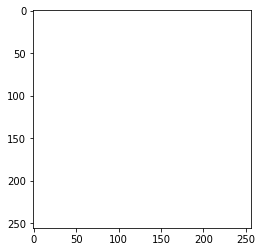

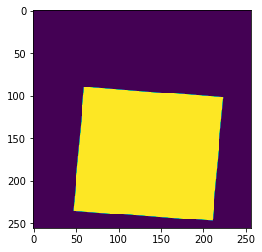

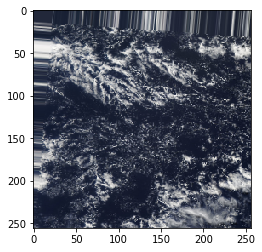

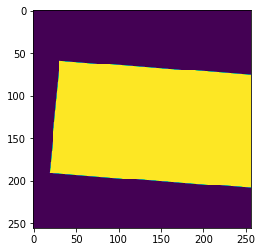

In [261]:
i = 0
plt.imshow(X[0]);plt.show()
plt.imshow(y[0,:,:,0]);plt.show()
plt.imshow(X2[0]);plt.show()
plt.imshow(y2[0,:, :, 0]);plt.show()

In [314]:
def build_model(): 
    # Build U-Net model
    inputs = Input((256, 256, 3))

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    #model.summary()
    return model

In [263]:
813//16, 90//16

(50, 5)

In [120]:
model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=5
)

Epoch 1/50
50/50 [==============================] - 51s 1s/step - loss: 0.3516 - mean_iou: 0.4412 - val_loss: 0.2427 - val_mean_iou: 0.4407
Epoch 2/50
50/50 [==============================] - 47s 932ms/step - loss: 0.3450 - mean_iou: 0.4410 - val_loss: 0.1923 - val_mean_iou: 0.4407
Epoch 3/50
50/50 [==============================] - 47s 943ms/step - loss: 0.3326 - mean_iou: 0.4409 - val_loss: 0.1754 - val_mean_iou: 0.4408
Epoch 4/50
50/50 [==============================] - 48s 954ms/step - loss: 0.3191 - mean_iou: 0.4410 - val_loss: 0.1637 - val_mean_iou: 0.4411
Epoch 5/50
50/50 [==============================] - 48s 964ms/step - loss: 0.3142 - mean_iou: 0.4414 - val_loss: 0.2054 - val_mean_iou: 0.4412
Epoch 6/50
50/50 [==============================] - 48s 956ms/step - loss: 0.3167 - mean_iou: 0.4412 - val_loss: 0.2420 - val_mean_iou: 0.4413
Epoch 7/50
50/50 [==============================] - 48s 964ms/step - loss: 0.3081 - mean_iou: 0.4414 - val_loss: 0.1710 - val_mean_iou: 0.4414
Ep

KeyboardInterrupt: 

In [268]:
def train_model(c, epochs=15):
    train_gen, valid_gen = create_gens(c)
    m = build_model()
    m.fit_generator(
        train_gen,
        steps_per_epoch=50,
        epochs=epochs,
        validation_data=valid_gen,
        validation_steps=5
    )
    return m

In [270]:
for c in cats[1:]:
    print(c)
    m = train_model(c)
    m.save(f'/local/S.Rasp/tmp/{c}.h5')

Flower
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, 256, 256, 8)  224         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 256, 256, 8)  584         conv2d_191[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_192[0][0]                 
__________________________________________________________________________________________________
con

Epoch 8/15
50/50 [==============================] - 12s 249ms/step - loss: 0.2947 - mean_iou: 0.4587 - val_loss: 0.2613 - val_mean_iou: 0.4588
Epoch 9/15
50/50 [==============================] - 13s 250ms/step - loss: 0.2831 - mean_iou: 0.4587 - val_loss: 0.2714 - val_mean_iou: 0.4588
Epoch 10/15
50/50 [==============================] - 12s 248ms/step - loss: 0.2874 - mean_iou: 0.4589 - val_loss: 0.2579 - val_mean_iou: 0.4589
Epoch 11/15
50/50 [==============================] - 13s 252ms/step - loss: 0.3046 - mean_iou: 0.4588 - val_loss: 0.2538 - val_mean_iou: 0.4586
Epoch 12/15
50/50 [==============================] - 13s 252ms/step - loss: 0.2777 - mean_iou: 0.4588 - val_loss: 0.2267 - val_mean_iou: 0.4589
Epoch 13/15
50/50 [==============================] - 13s 256ms/step - loss: 0.2852 - mean_iou: 0.4589 - val_loss: 0.2734 - val_mean_iou: 0.4588
Epoch 14/15
50/50 [==============================] - 13s 254ms/step - loss: 0.2917 - mean_iou: 0.4589 - val_loss: 0.2814 - val_mean_iou: 0

Epoch 1/15
50/50 [==============================] - 15s 298ms/step - loss: 0.5936 - mean_iou: 0.4651 - val_loss: 0.3182 - val_mean_iou: 0.4817
Epoch 2/15
50/50 [==============================] - 12s 250ms/step - loss: 0.6182 - mean_iou: 0.4809 - val_loss: 0.3053 - val_mean_iou: 0.4821
Epoch 3/15
50/50 [==============================] - 12s 249ms/step - loss: 0.5739 - mean_iou: 0.4825 - val_loss: 0.3098 - val_mean_iou: 0.4825
Epoch 4/15
50/50 [==============================] - 13s 261ms/step - loss: 0.5486 - mean_iou: 0.4830 - val_loss: 0.3111 - val_mean_iou: 0.4829
Epoch 5/15
50/50 [==============================] - 13s 252ms/step - loss: 0.6239 - mean_iou: 0.4826 - val_loss: 0.3061 - val_mean_iou: 0.4827
Epoch 6/15
50/50 [==============================] - 13s 253ms/step - loss: 0.6236 - mean_iou: 0.4825 - val_loss: 0.3160 - val_mean_iou: 0.4826
Epoch 7/15
50/50 [==============================] - 13s 255ms/step - loss: 0.5846 - mean_iou: 0.4825 - val_loss: 0.3137 - val_mean_iou: 0.4826

Epoch 1/15
50/50 [==============================] - 15s 308ms/step - loss: 0.5188 - mean_iou: 0.4317 - val_loss: 0.4296 - val_mean_iou: 0.4421
Epoch 2/15
50/50 [==============================] - 13s 250ms/step - loss: 0.3492 - mean_iou: 0.4430 - val_loss: 0.3837 - val_mean_iou: 0.4424
Epoch 3/15
50/50 [==============================] - 12s 250ms/step - loss: 0.3458 - mean_iou: 0.4425 - val_loss: 0.4037 - val_mean_iou: 0.4428
Epoch 4/15
50/50 [==============================] - 13s 255ms/step - loss: 0.3455 - mean_iou: 0.4423 - val_loss: 0.3965 - val_mean_iou: 0.4422
Epoch 5/15
50/50 [==============================] - 13s 254ms/step - loss: 0.3192 - mean_iou: 0.4425 - val_loss: 0.4840 - val_mean_iou: 0.4425
Epoch 6/15
50/50 [==============================] - 13s 251ms/step - loss: 0.3371 - mean_iou: 0.4429 - val_loss: 0.3775 - val_mean_iou: 0.4427
Epoch 7/15
50/50 [==============================] - 13s 251ms/step - loss: 0.3274 - mean_iou: 0.4425 - val_loss: 0.3960 - val_mean_iou: 0.4426

Epoch 1/15
50/50 [==============================] - 16s 314ms/step - loss: 0.4277 - mean_iou: 0.4471 - val_loss: 0.2126 - val_mean_iou: 0.4669
Epoch 2/15
50/50 [==============================] - 13s 261ms/step - loss: 0.2556 - mean_iou: 0.4679 - val_loss: 0.2482 - val_mean_iou: 0.4675
Epoch 3/15
50/50 [==============================] - 13s 255ms/step - loss: 0.2473 - mean_iou: 0.4679 - val_loss: 0.2572 - val_mean_iou: 0.4674
Epoch 4/15
50/50 [==============================] - 13s 254ms/step - loss: 0.2320 - mean_iou: 0.4673 - val_loss: 0.1859 - val_mean_iou: 0.4674
Epoch 5/15
50/50 [==============================] - 13s 256ms/step - loss: 0.2340 - mean_iou: 0.4676 - val_loss: 0.2170 - val_mean_iou: 0.4676
Epoch 6/15
50/50 [==============================] - 13s 255ms/step - loss: 0.2222 - mean_iou: 0.4675 - val_loss: 0.2004 - val_mean_iou: 0.4673
Epoch 7/15
50/50 [==============================] - 13s 258ms/step - loss: 0.2118 - mean_iou: 0.4676 - val_loss: 0.1889 - val_mean_iou: 0.4676

In [276]:
models = {c: keras.models.load_model(f'/local/S.Rasp/tmp/{c}.h5', 
                                     custom_objects={'mean_iou': mean_iou}) for c in cats[1:]}

In [306]:
def check_preds(i):
    X = imgs_re[i]; Y = tot_masks_re[i]
    preds = [models[c].predict(X[None])[0, :, :, 0] for c in cats[1:]]
    plt.imshow(X); plt.show()
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    for i, ax in enumerate(axs.flat):
        ax.set_title(cats[i+1])
        ax.imshow(Y[:, :, i+1], vmin=0, vmax=1)
    plt.show()
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    for i, ax in enumerate(axs.flat):
        ax.set_title(cats[i+1])
        ax.imshow(preds[i], vmin=0, vmax=1)

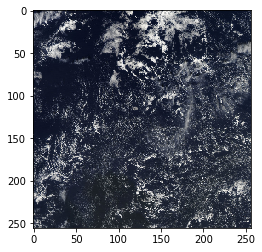

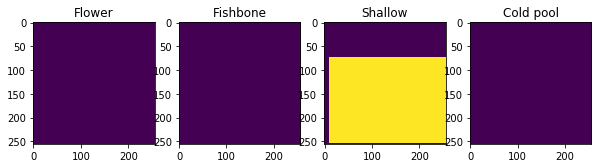

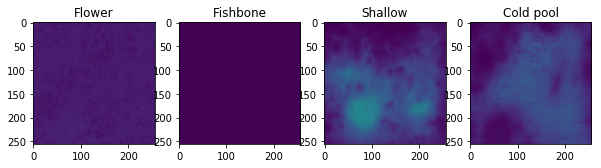

In [321]:
check_preds(14)

In [155]:
X, Y = next(train_generator)

In [156]:
preds = model.predict(X)

In [157]:
X.shape, Y.shape, preds.shape

((16, 256, 256, 3), (16, 256, 256, 1), (16, 256, 256, 1))

In [158]:
Y[0].shape

(256, 256, 1)

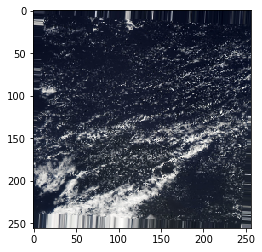

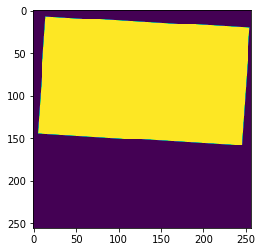

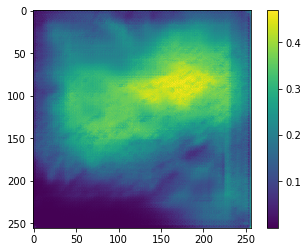

In [172]:
i=11
plt.imshow(X[i]); plt.show()
plt.imshow(Y[i, :, :, 0]); plt.show()
plt.imshow(preds[i, :, :, 0]); plt.colorbar(); plt.show()

## Multi-class Unet

In [23]:
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

In [121]:
imgs_re = [resize(imgs[i], (256, 256)) for i in range(len(imgs))]

In [122]:
imgs_re = np.array(imgs_re); imgs_re.shape

(903, 256, 256, 3)

In [144]:
tot_masks

array([[[[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        ...,

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0],
         ...,
         [1, 0, 0, 0, 0],
        

In [150]:
tot_masks_re = [resize(tot_masks[i]*255, (256, 256)) for i in range(len(imgs))]
tot_masks_re = np.array(tot_masks_re); tot_masks_re.shape

(903, 256, 256, 5)

In [151]:
tot_masks_re

array([[[[1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         ...,
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ]],

        [[1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         ...,
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ]],

        [[1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         [1.      , 0.      , 0.      , 0.      , 0.      ],
         ...,
         [1.      , 0.      , 0.      ,

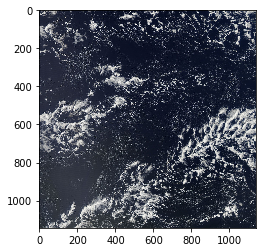

In [124]:
plt.imshow(imgs[7])

In [125]:
np.mean(tot_masks[1, :, :, 0])

0.7187078272604588

In [70]:
tot_masks_re

array([[[[0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157,

In [147]:
1/0.00392157

254.99991075003123

In [126]:
np.mean(tot_masks, (0, 1, 2))

array([0.68100023, 0.08898475, 0.0364641 , 0.12390942, 0.0696415 ])

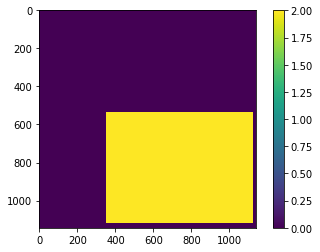

In [127]:
plt.imshow(np.array(Image.open(MASK_PATH + fns[7]))); plt.colorbar()

In [98]:
cats

['No fit', 'Flower', 'Fishbone', 'Shallow', 'Cold pool']

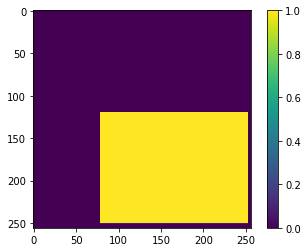

In [152]:
plt.imshow(tot_masks_re[7, :, :, 2]); plt.colorbar()

In [153]:
data_gen_args = dict(rotation_range=15.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=0.1
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args, )

In [154]:
seed = 1
bs = 16

In [155]:
train_generator = zip(
    image_datagen.flow(
        imgs_re,
        batch_size=bs,
        seed=seed,
        subset='training'
    ),
    mask_datagen.flow(
        tot_masks_re,
        batch_size=bs,
        seed=seed,
        subset='training',
    )
)

In [156]:
valid_generator = zip(
    image_datagen.flow(
        imgs_re,
        batch_size=bs,
        seed=seed,
        subset='validation'
    ),
    mask_datagen.flow(
        tot_masks_re,
        batch_size=bs,
        seed=seed,
        subset='validation',
    )
)

In [157]:
# Build U-Net model
inputs = Input((256, 256, 3))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(5, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 8)  224         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 8)  584         conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_78[0][0]                  
__________________________________________________________________________________________________
conv2d_79 

In [169]:
model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=5
)

Epoch 1/10
50/50 [==============================] - 27s 544ms/step - loss: 0.9870 - acc: 0.6908 - val_loss: 0.9619 - val_acc: 0.7202
Epoch 2/10
50/50 [==============================] - 24s 479ms/step - loss: 0.9575 - acc: 0.7031 - val_loss: 0.9171 - val_acc: 0.7304
Epoch 3/10
50/50 [==============================] - 24s 488ms/step - loss: 0.9693 - acc: 0.6958 - val_loss: 0.9037 - val_acc: 0.7214
Epoch 4/10
50/50 [==============================] - 25s 492ms/step - loss: 0.9585 - acc: 0.6976 - val_loss: 0.9258 - val_acc: 0.7153
Epoch 5/10
50/50 [==============================] - 25s 493ms/step - loss: 0.9650 - acc: 0.6937 - val_loss: 0.9292 - val_acc: 0.7110
Epoch 6/10
50/50 [==============================] - 26s 521ms/step - loss: 0.9514 - acc: 0.6968 - val_loss: 0.8919 - val_acc: 0.7280
Epoch 7/10
50/50 [==============================] - 26s 510ms/step - loss: 0.9492 - acc: 0.7009 - val_loss: 0.9187 - val_acc: 0.7241
Epoch 8/10
50/50 [==============================] - 26s 520ms/step - 

In [170]:
X, Y = next(train_generator)

In [171]:
X

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.06717337, 0.08649661, 0.16839676],
         [0.04793158, 0.07692137, 0.15156502],
         [0.04885205, 0.07348982, 0.15768139]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.06745662, 0.08693762, 0.16848554],
         [0.04820507, 0.07703545, 0.1518159 ],
         [0.0487999 , 0.07352984, 0.1575482 ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.06773986, 0.08737862, 0.16857433],
         [0.04847855, 0.07714952, 0.15206681],
         [0.04874776, 0.07356986, 0.15741503]],

        ...,

        [[0.753462  , 0.76130515, 0.7416973 ],
         [0.753462  , 0.76130515, 0.7416973 ]

In [172]:
preds = model.predict(X)

In [173]:
X.shape, Y.shape, preds.shape

((13, 256, 256, 3), (13, 256, 256, 5), (13, 256, 256, 5))

In [174]:
Y, preds

(array([[[[1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          ...,
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ]],
 
         [[1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          ...,
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ]],
 
         [[1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          [1.      , 0.      , 0.      , 0.      , 0.      ],
          ...,
          [1.      

In [175]:
def show_preds(X, Y, idx):
    plt.imshow(X[idx]); plt.show()
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    axs=axs.flat
    for i in range(len(cats)):
        axs[i].set_title(cats[i])
        axs[i].imshow(Y[idx, :, :, i], vmin=0, vmax=1)
    plt.show()
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    axs=axs.flat
    for i in range(len(cats)):
        axs[i].set_title(cats[i])
        axs[i].imshow(preds[idx, :, :, i], vmin=0, vmax=1)
    plt.show()

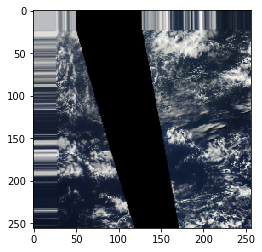

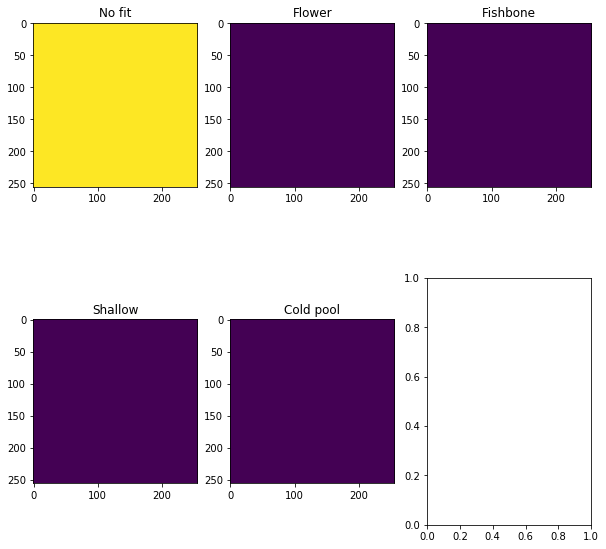

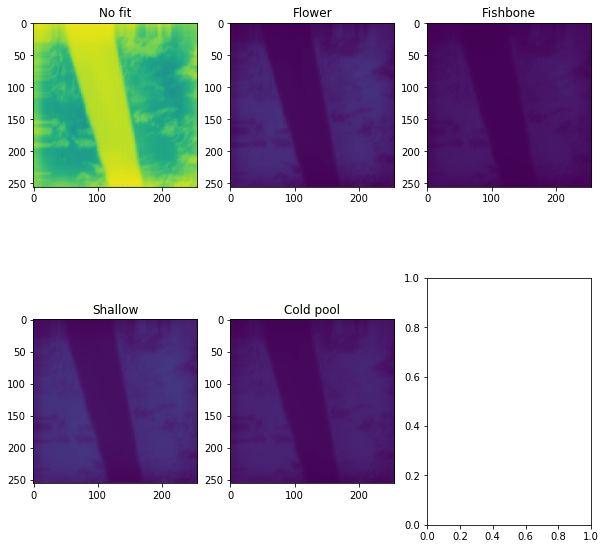

In [179]:
show_preds(X, Y, 4)

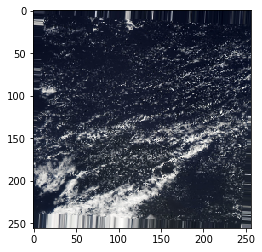

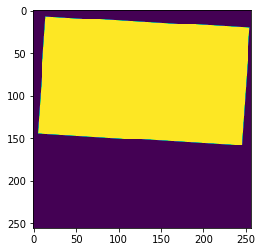

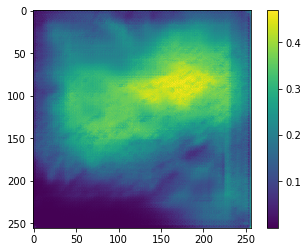

In [172]:
i=11
plt.imshow(X[i]); plt.show()
plt.imshow(Y[i, :, :, 0]); plt.show()
plt.imshow(preds[i, :, :, 0]); plt.colorbar(); plt.show()